# Divvy Bike Sharing Data Platform - Complete Pipeline

**Team:** Felix, Tun, Sebi, Oli  
**Course:** Data Engineering  
**Date:** October 2025

## Overview

This notebook demonstrates the complete end-to-end pipeline for the Divvy bike-sharing analytics platform:

1. **Setup & Configuration** - Initialize environment and dependencies
2. **Database Initialization** - Create SQLite schema
3. **Data Exploration** - Load and explore raw CSV trip data
4. **ETL Pipeline** - Extract stations and transform to hourly deltas using PySpark
5. **Data Loading** - Write processed data to SQLite database
6. **Analysis & Visualization** - Query results and create insights
7. **Results** - Station balances, imbalance detection, and operational metrics

## Architecture

```
CSV Trip Data → PySpark ETL → SQLite Database → Analysis & Visualization
```


## 1. Setup & Configuration

Import required libraries and configure project paths.


In [1]:
import sys
from pathlib import Path
from datetime import datetime
import sqlite3

# Add project root to path
PROJECT_ROOT = Path.cwd()
sys.path.insert(0, str(PROJECT_ROOT))

# Import PySpark
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, DoubleType

# Import project modules
from database.connection import DatabaseConnection
from database.repositories import StationRepository, EventsHourlyRepository
from config.database import DB_PATH, TIMEZONE, INITIAL_BALANCE

print(f"✓ Project Root: {PROJECT_ROOT}")
print(f"✓ Database Path: {DB_PATH}")
print(f"✓ Timezone: {TIMEZONE}")
print(f"✓ Initial Balance: {INITIAL_BALANCE} bikes per station")


✓ Project Root: /Users/tunkeltesch/Desktop/Uni-Repos/Data-Engeneering
✓ Database Path: /Users/tunkeltesch/Desktop/Uni-Repos/Data-Engeneering/data/app.db
✓ Timezone: America/Chicago
✓ Initial Balance: 20 bikes per station


## 2. Database Initialization

Create the SQLite database schema with two tables:
- **station**: Station catalog (id, name, location, capacity)
- **events_hourly**: Hourly deltas per station (hour, station_id, delta_total)


In [2]:
# Initialize database
db = DatabaseConnection(DB_PATH)
db.initialize_schema()

# Verify tables were created
with db.get_connection() as conn:
    cursor = conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
    tables = [row[0] for row in cursor.fetchall()]
    
print("✓ Database initialized successfully")
print(f"  Tables created: {', '.join(tables)}")


✓ Database initialized: /Users/tunkeltesch/Desktop/Uni-Repos/Data-Engeneering/data/app.db
✓ Database initialized successfully
  Tables created: station, events_hourly


## 3. Initialize PySpark

Create Spark session configured for Chicago timezone.


In [3]:
# Build Spark session
spark = (
    SparkSession.builder
    .appName("DivvyBikeSharingETL")
    .config("spark.sql.shuffle.partitions", "4")
    .config("spark.sql.session.timeZone", TIMEZONE)
    .getOrCreate()
)
spark.sparkContext.setLogLevel("WARN")

print(f"✓ Spark session created")
print(f"  Version: {spark.version}")
print(f"  Timezone: {TIMEZONE}")


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/05 19:18:30 WARN Utils: Your hostname, SM1LE-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 172.20.10.12 instead (on interface en0)
25/11/05 19:18:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/05 19:18:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


✓ Spark session created
  Version: 4.0.1
  Timezone: America/Chicago


## 4. Load Raw Trip Data

Load Divvy trip CSV files from `data/tripdata/` directory.


In [4]:
# Define schema for trip data
ride_schema = StructType([
    StructField("ride_id", StringType(), True),
    StructField("rideable_type", StringType(), True),
    StructField("started_at", TimestampType(), True),
    StructField("ended_at", TimestampType(), True),
    StructField("start_station_name", StringType(), True),
    StructField("start_station_id", StringType(), True),
    StructField("end_station_name", StringType(), True),
    StructField("end_station_id", StringType(), True),
    StructField("start_lat", DoubleType(), True),
    StructField("start_lng", DoubleType(), True),
    StructField("end_lat", DoubleType(), True),
    StructField("end_lng", DoubleType(), True),
    StructField("member_casual", StringType(), True),
])

# Load CSV files
data_path = PROJECT_ROOT / "data" / "tripdata"
csv_pattern = str(data_path / "*.csv")

df = (
    spark.read
    .option("header", True)
    .schema(ride_schema)
    .csv(csv_pattern)
)

# Show data info
trip_count = df.count()
print(f"✓ Loaded {trip_count:,} trips from CSV files")
print(f"  Data path: {data_path}")
print(f"\nSchema:")
df.printSchema()


25/11/05 19:18:39 WARN FileStreamSink: Assume no metadata directory. Error while looking for metadata directory in the path: /Users/tunkeltesch/Desktop/Uni-Repos/Data-Engeneering/data/tripdata/*.csv.
java.io.FileNotFoundException: File /Users/tunkeltesch/Desktop/Uni-Repos/Data-Engeneering/data/tripdata/*.csv does not exist
	at org.apache.hadoop.fs.RawLocalFileSystem.deprecatedGetFileStatus(RawLocalFileSystem.java:917)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileLinkStatusInternal(RawLocalFileSystem.java:1238)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileStatus(RawLocalFileSystem.java:907)
	at org.apache.hadoop.fs.FilterFileSystem.getFileStatus(FilterFileSystem.java:462)
	at org.apache.spark.sql.execution.streaming.FileStreamSink$.hasMetadata(FileStreamSink.scala:56)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:381)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource.org$apache$spark$sql$catalyst$analysis$ResolveDataSou

✓ Loaded 5,719,877 trips from CSV files
  Data path: /Users/tunkeltesch/Desktop/Uni-Repos/Data-Engeneering/data/tripdata

Schema:
root
 |-- ride_id: string (nullable = true)
 |-- rideable_type: string (nullable = true)
 |-- started_at: timestamp (nullable = true)
 |-- ended_at: timestamp (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_id: string (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_id: string (nullable = true)
 |-- start_lat: double (nullable = true)
 |-- start_lng: double (nullable = true)
 |-- end_lat: double (nullable = true)
 |-- end_lng: double (nullable = true)
 |-- member_casual: string (nullable = true)



### 4.1 Sample Data

View first few rows of trip data.


In [5]:
# Display sample trips
df.select(
    "ride_id", 
    "rideable_type", 
    "started_at", 
    "start_station_id", 
    "start_station_name",
    "end_station_id",
    "end_station_name"
).show(5, truncate=False)


+----------------+-------------+-------------------+----------------+------------------+--------------+----------------+
|ride_id         |rideable_type|started_at         |start_station_id|start_station_name|end_station_id|end_station_name|
+----------------+-------------+-------------------+----------------+------------------+--------------+----------------+
|6F1682AC40EB6F71|electric_bike|2023-06-05 13:34:12|NULL            |NULL              |NULL          |NULL            |
|622A1686D64948EB|electric_bike|2023-06-05 01:30:22|NULL            |NULL              |NULL          |NULL            |
|3C88859D926253B4|electric_bike|2023-06-20 18:15:49|NULL            |NULL              |NULL          |NULL            |
|EAD8A5E0259DEC88|electric_bike|2023-06-19 14:56:00|NULL            |NULL              |NULL          |NULL            |
|5A36F21930D6A55C|electric_bike|2023-06-19 15:03:34|NULL            |NULL              |NULL          |NULL            |
+----------------+-------------+

### 4.2 Data Statistics

Quick statistics about the trip data.


In [6]:
# Count bike types
print("Bike Types Distribution:")
df.groupBy("rideable_type").count().orderBy("count", ascending=False).show()

# Date range
print("\nDate Range:")
df.select(
    F.min("started_at").alias("earliest_trip"),
    F.max("ended_at").alias("latest_trip")
).show(truncate=False)

# Count unique stations
start_stations = df.select("start_station_id").distinct().count()
end_stations = df.select("end_station_id").distinct().count()
print(f"\nUnique start stations: {start_stations}")
print(f"Unique end stations: {end_stations}")


Bike Types Distribution:


+-------------+-------+
|rideable_type|  count|
+-------------+-------+
|electric_bike|2945579|
| classic_bike|2696011|
|  docked_bike|  78287|
+-------------+-------+


Date Range:


+-------------------+-------------------+
|earliest_trip      |latest_trip        |
+-------------------+-------------------+
|2023-01-01 00:01:58|2024-01-01 23:50:51|
+-------------------+-------------------+




Unique start stations: 1517
Unique end stations: 1521


### 4.3 Data Quality - NULL Station Analysis

Some trips (especially dockless electric bikes) don't have station information. Let's analyze this pattern.


In [7]:
# Analyze NULL stations by bike type
print("🔍 NULL STATION ANALYSIS\n")

# Count trips with NULL start or end stations
null_start = df.filter(F.col("start_station_id").isNull()).count()
null_end = df.filter(F.col("end_station_id").isNull()).count()
null_both = df.filter(F.col("start_station_id").isNull() | F.col("end_station_id").isNull()).count()

print(f"Trips with NULL start station: {null_start:,} ({null_start/trip_count*100:.1f}%)")
print(f"Trips with NULL end station: {null_end:,} ({null_end/trip_count*100:.1f}%)")
print(f"Trips with any NULL station: {null_both:,} ({null_both/trip_count*100:.1f}%)")

# Analyze by bike type
print("\n📊 NULL Stations by Bike Type:")
df.groupBy("rideable_type").agg(
    F.count("*").alias("total_trips"),
    F.sum(F.when(F.col("start_station_id").isNull(), 1).otherwise(0)).alias("null_start"),
    F.sum(F.when(F.col("end_station_id").isNull(), 1).otherwise(0)).alias("null_end")
).withColumn(
    "null_start_pct",
    (F.col("null_start") / F.col("total_trips") * 100)
).withColumn(
    "null_end_pct", 
    (F.col("null_end") / F.col("total_trips") * 100)
).show()

# Count usable trips for station analysis
usable_trips = df.filter(
    F.col("start_station_id").isNotNull() & F.col("end_station_id").isNotNull()
).count()

print(f"\n✓ Usable trips for station analysis: {usable_trips:,} ({usable_trips/trip_count*100:.1f}%)")
print(f"✗ Excluded (dockless/NULL): {trip_count - usable_trips:,} ({(trip_count - usable_trips)/trip_count*100:.1f}%)")

print("\nNOTE: Electric bikes are often 'dockless' - users can pick up/drop off")
print("   anywhere, not just at stations. These trips are excluded from our")
print("   station-based rebalancing analysis.")


🔍 NULL STATION ANALYSIS



Trips with NULL start station: 875,848 (15.3%)
Trips with NULL end station: 929,343 (16.2%)
Trips with any NULL station: 1,388,054 (24.3%)

📊 NULL Stations by Bike Type:


+-------------+-----------+----------+--------+--------------------+------------------+
|rideable_type|total_trips|null_start|null_end|      null_start_pct|      null_end_pct|
+-------------+-----------+----------+--------+--------------------+------------------+
| classic_bike|    2696011|       102|    5194|0.003783367352729644|0.1926550002948801|
|electric_bike|    2945579|    875746|  922102|   29.73086106330878| 31.30460938239986|
|  docked_bike|      78287|         0|    2047|                 0.0|2.6147380791191384|
+-------------+-----------+----------+--------+--------------------+------------------+




✓ Usable trips for station analysis: 4,331,823 (75.7%)
✗ Excluded (dockless/NULL): 1,388,054 (24.3%)

NOTE: Electric bikes are often 'dockless' - users can pick up/drop off
   anywhere, not just at stations. These trips are excluded from our
   station-based rebalancing analysis.


## 5. ETL Pipeline - Extract Stations

Extract unique station catalog from trip data (filters out NULL/dockless trips).


In [8]:
# Extract start stations
start_stations = df.select(
    F.col("start_station_id").alias("station_id"),
    F.col("start_station_name").alias("station_name")
)

# Extract end stations
end_stations = df.select(
    F.col("end_station_id").alias("station_id"),
    F.col("end_station_name").alias("station_name")
)

# Union and deduplicate
stations_df = (
    start_stations.union(end_stations)
    .filter(F.col("station_id").isNotNull())
    .filter(F.col("station_name").isNotNull())
    .dropDuplicates(["station_id"])
    .orderBy("station_id")
)

station_count = stations_df.count()
print(f"✓ Extracted {station_count} unique stations")
print("\nSample stations:")
stations_df.show(10, truncate=False)


✓ Extracted 1535 unique stations

Sample stations:


+----------+----------------------------------------------+
|station_id|station_name                                  |
+----------+----------------------------------------------+
|021320    |MTV Hubbard St                                |
|1011      |Public Rack - Fullerton Ave & Narragansett Ave|
|1012      |Public Rack - Langley Ave & 49th St           |
|1013      |Public Rack - Pulaski Rd & Lake St            |
|1015      |Public Rack - Peterson Ave & Drake Ave        |
|1016      |Public Rack - Peterson Ave & Bernard Ave      |
|1017      |Public Rack - Foster Ave & Drake Ave          |
|1018      |Public Rack - Kostner Ave & Wrightwood Ave    |
|1019      |Public Rack - Kostner Ave & Diversey Ave      |
|1020      |Public Rack - Hamlin Ave & Madison St         |
+----------+----------------------------------------------+
only showing top 10 rows


## 6. ETL Pipeline - Transform to Hourly Deltas

Transform trips into hourly station balance changes:
- Departure (start): -1 bike from station
- Arrival (end): +1 bike to station
- Aggregate by (hour, station_id)
- **Note**: Trips with NULL stations are automatically filtered out


In [9]:
# Floor timestamps to hour
df_with_hours = df.withColumn(
    "start_hour",
    F.date_format(
        F.date_trunc("hour", F.col("started_at")),
        "yyyy-MM-dd HH:00:00"
    )
).withColumn(
    "end_hour",
    F.date_format(
        F.date_trunc("hour", F.col("ended_at")),
        "yyyy-MM-dd HH:00:00"
    )
)

# Create departure events (delta = -1)
departures = (
    df_with_hours
    .filter(F.col("start_station_id").isNotNull())
    .select(
        F.col("start_hour").alias("hour"),
        F.col("start_station_id").alias("station_id"),
        F.lit(-1).alias("delta")
    )
)

# Create arrival events (delta = +1)
arrivals = (
    df_with_hours
    .filter(F.col("end_station_id").isNotNull())
    .select(
        F.col("end_hour").alias("hour"),
        F.col("end_station_id").alias("station_id"),
        F.lit(1).alias("delta")
    )
)

# Union and aggregate
hourly_deltas_df = (
    departures.union(arrivals)
    .groupBy("hour", "station_id")
    .agg(F.sum("delta").alias("delta_total"))
    .orderBy("hour", "station_id")
)

hourly_event_count = hourly_deltas_df.count()
print(f"✓ Generated {hourly_event_count:,} hourly events")
print("\nSample hourly deltas:")
hourly_deltas_df.show(10)


✓ Generated 2,394,066 hourly events

Sample hourly deltas:


+-------------------+----------+-----------+
|               hour|station_id|delta_total|
+-------------------+----------+-----------+
|2023-01-01 00:00:00|     13006|         -2|
|2023-01-01 00:00:00|     13008|         -1|
|2023-01-01 00:00:00|     13016|          1|
|2023-01-01 00:00:00|     13021|         -1|
|2023-01-01 00:00:00|     13022|        -19|
|2023-01-01 00:00:00|     13034|         -3|
|2023-01-01 00:00:00|     13042|         -1|
|2023-01-01 00:00:00|     13056|          1|
|2023-01-01 00:00:00|     13061|         -1|
|2023-01-01 00:00:00|     13063|          3|
+-------------------+----------+-----------+
only showing top 10 rows


## 7. Load Data into SQLite Database

Write extracted stations and hourly events to SQLite using repository pattern.


In [10]:
# Convert Spark DataFrames to Python lists for repository
stations_list = [
    {"id": row.station_id, "name": row.station_name}
    for row in stations_df.collect()
]

hourly_events_list = [
    {
        "hour": row.hour,
        "station_id": row.station_id,
        "delta_total": int(row.delta_total)
    }
    for row in hourly_deltas_df.collect()
]

print(f"✓ Converted {len(stations_list)} stations to list")
print(f"✓ Converted {len(hourly_events_list):,} hourly events to list")


✓ Converted 1535 stations to list
✓ Converted 2,394,066 hourly events to list


In [11]:
# Write to SQLite database using repositories
print("Writing to database...")

with db.get_connection() as conn:
    # Write stations
    station_repo = StationRepository(conn)
    stations_written = station_repo.upsert_stations_batch(stations_list)
    print(f"✓ Upserted {stations_written} stations to database")
    
    # Write hourly events
    events_repo = EventsHourlyRepository(conn)
    events_written = events_repo.upsert_hourly_events_batch(hourly_events_list)
    print(f"✓ Upserted {events_written:,} hourly events to database")

print(f"\n✓ Database updated successfully at: {DB_PATH}")


Writing to database...
✓ Upserted 1535 stations to database
✓ Upserted 2,394,066 hourly events to database

✓ Database updated successfully at: /Users/tunkeltesch/Desktop/Uni-Repos/Data-Engeneering/data/app.db


## 8. Data Analysis & Visualization

Query the database to analyze station balances and identify imbalances.


In [12]:
# Import visualization libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Configure plot style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline


### 8.1 Overall Station Balance Analysis

Calculate net balance changes for all stations across the entire time period.


In [13]:
# Query overall balance for all stations
with db.get_connection() as conn:
    query = """
        SELECT 
            s.id as station_id,
            s.name as station_name,
            COALESCE(SUM(e.delta_total), 0) as net_change,
            ? + COALESCE(SUM(e.delta_total), 0) as final_balance
        FROM station s
        LEFT JOIN events_hourly e ON s.id = e.station_id
        WHERE s.is_active = 1
        GROUP BY s.id, s.name
        ORDER BY net_change DESC
    """
    balance_df = pd.read_sql_query(query, conn, params=(INITIAL_BALANCE,))

print(f"✓ Loaded balances for {len(balance_df)} stations\n")
print("Top 10 stations with most bikes accumulated:")
print(balance_df.head(10)[['station_name', 'net_change', 'final_balance']].to_string(index=False))
print("\nTop 10 stations with most bikes depleted:")
print(balance_df.tail(10)[['station_name', 'net_change', 'final_balance']].to_string(index=False))


✓ Loaded balances for 1535 stations

Top 10 stations with most bikes accumulated:
                      station_name  net_change  final_balance
DuSable Lake Shore Dr & North Blvd        3335           3355
      Sheffield Ave & Waveland Ave        2921           2941
           Green St & Randolph St*        2893           2913
             Sangamon St & Lake St        1936           1956
          Lincoln Ave & Roscoe St*        1437           1457
            Damen Ave & Pierce Ave        1365           1385
           Wood St & Milwaukee Ave        1148           1168
           Clinton St & Madison St        1117           1137
      Southport Ave & Clybourn Ave        1102           1122
        Wentworth Ave & Cermak Rd*        1095           1115

Top 10 stations with most bikes depleted:
                     station_name  net_change  final_balance
            State St & Pearson St       -1541          -1521
                Adler Planetarium       -1974          -1954
          

### 8.2 Balance Distribution Visualization

Visualize the distribution of final balances across all stations.


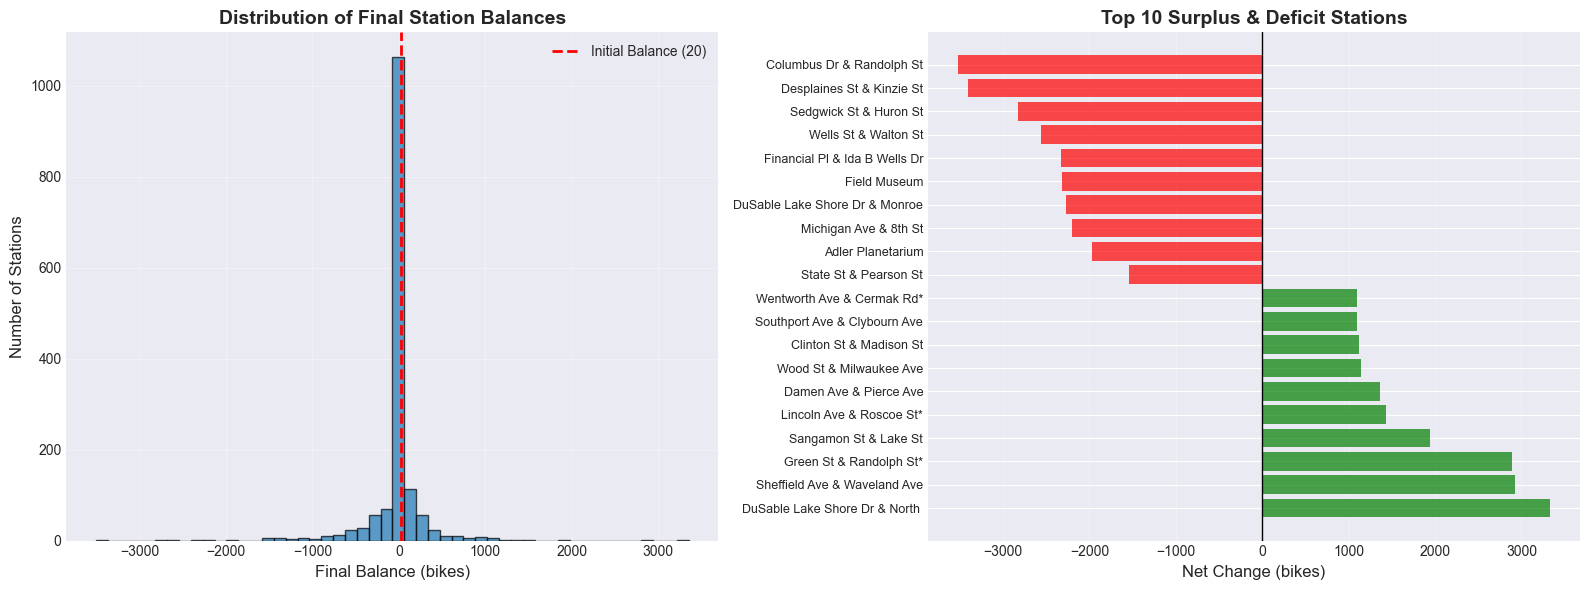


Balance Statistics:
  Mean final balance: -14.9 bikes
  Median final balance: 19.0 bikes
  Std deviation: 366.0 bikes
  Min: -3505 bikes
  Max: 3355 bikes


In [14]:
# Plot balance distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram of final balances
axes[0].hist(balance_df['final_balance'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(INITIAL_BALANCE, color='red', linestyle='--', linewidth=2, label=f'Initial Balance ({INITIAL_BALANCE})')
axes[0].set_xlabel('Final Balance (bikes)', fontsize=12)
axes[0].set_ylabel('Number of Stations', fontsize=12)
axes[0].set_title('Distribution of Final Station Balances', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Bar chart of top 20 stations by net change
top_20 = pd.concat([balance_df.head(10), balance_df.tail(10)]).sort_values('net_change', ascending=False)
colors = ['green' if x > 0 else 'red' for x in top_20['net_change']]
axes[1].barh(range(len(top_20)), top_20['net_change'], color=colors, alpha=0.7)
axes[1].set_yticks(range(len(top_20)))
axes[1].set_yticklabels([name[:30] for name in top_20['station_name']], fontsize=9)
axes[1].set_xlabel('Net Change (bikes)', fontsize=12)
axes[1].set_title('Top 10 Surplus & Deficit Stations', fontsize=14, fontweight='bold')
axes[1].axvline(0, color='black', linewidth=1)
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Print statistics
print(f"\nBalance Statistics:")
print(f"  Mean final balance: {balance_df['final_balance'].mean():.1f} bikes")
print(f"  Median final balance: {balance_df['final_balance'].median():.1f} bikes")
print(f"  Std deviation: {balance_df['final_balance'].std():.1f} bikes")
print(f"  Min: {balance_df['final_balance'].min():.0f} bikes")
print(f"  Max: {balance_df['final_balance'].max():.0f} bikes")


### 8.3 Time-Series Analysis for Specific Station

Track balance changes over time for the station with highest deficit.


In [15]:
# Pick the station with highest deficit
target_station = balance_df.tail(1).iloc[0]
station_id = target_station['station_id']
station_name = target_station['station_name']

print(f"Analyzing: {station_name} (ID: {station_id})")
print(f"  Net change: {target_station['net_change']:.0f} bikes")
print(f"  Final balance: {target_station['final_balance']:.0f} bikes\n")

# Query hourly events for this station
with db.get_connection() as conn:
    query = """
        SELECT hour, delta_total
        FROM events_hourly
        WHERE station_id = ?
        ORDER BY hour
    """
    station_events = pd.read_sql_query(query, conn, params=(station_id,))

# Convert hour to datetime and calculate cumulative balance
station_events['hour'] = pd.to_datetime(station_events['hour'])
station_events['cumulative_balance'] = INITIAL_BALANCE + station_events['delta_total'].cumsum()

print(f"✓ Loaded {len(station_events)} hourly events")
print(f"\nTime range: {station_events['hour'].min()} to {station_events['hour'].max()}")


Analyzing: Columbus Dr & Randolph St (ID: 13263)
  Net change: -3525 bikes
  Final balance: -3505 bikes

✓ Loaded 6098 hourly events

Time range: 2023-01-01 00:00:00 to 2024-01-01 00:00:00


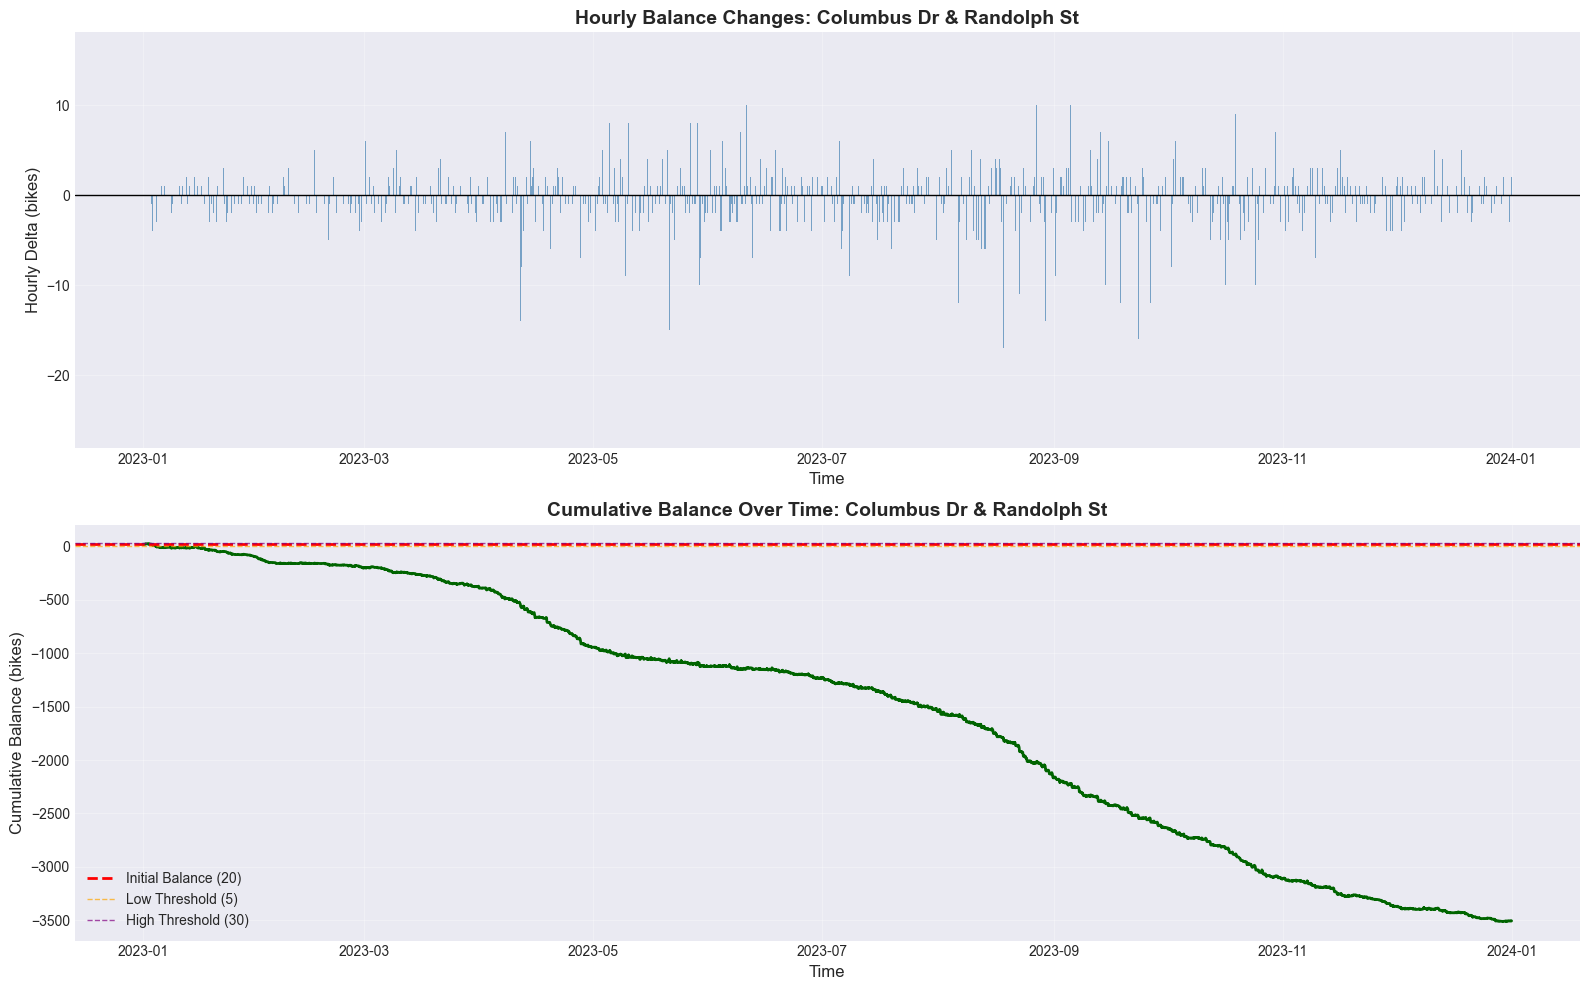

In [16]:
# Plot time series
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Hourly deltas
axes[0].bar(station_events['hour'], station_events['delta_total'], width=0.03, alpha=0.7, color='steelblue')
axes[0].axhline(0, color='black', linewidth=1)
axes[0].set_xlabel('Time', fontsize=12)
axes[0].set_ylabel('Hourly Delta (bikes)', fontsize=12)
axes[0].set_title(f'Hourly Balance Changes: {station_name}', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Cumulative balance
axes[1].plot(station_events['hour'], station_events['cumulative_balance'], linewidth=2, color='darkgreen')
axes[1].axhline(INITIAL_BALANCE, color='red', linestyle='--', linewidth=2, label=f'Initial Balance ({INITIAL_BALANCE})')
axes[1].axhline(5, color='orange', linestyle='--', linewidth=1, label='Low Threshold (5)', alpha=0.7)
axes[1].axhline(30, color='purple', linestyle='--', linewidth=1, label='High Threshold (30)', alpha=0.7)
axes[1].set_xlabel('Time', fontsize=12)
axes[1].set_ylabel('Cumulative Balance (bikes)', fontsize=12)
axes[1].set_title(f'Cumulative Balance Over Time: {station_name}', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 8.4 Critical Stations Detection

Identify stations that need immediate rebalancing attention.


In [17]:
# Import thresholds from config
from config.database import BALANCE_LOW_THRESHOLD, BALANCE_HIGH_THRESHOLD

# Identify critical stations
low_balance_stations = balance_df[balance_df['final_balance'] <= BALANCE_LOW_THRESHOLD]
high_balance_stations = balance_df[balance_df['final_balance'] >= BALANCE_HIGH_THRESHOLD]

print("CRITICAL STATIONS - LOW BALANCE (Need bikes added)")
print(f"   {len(low_balance_stations)} stations with ≤ {BALANCE_LOW_THRESHOLD} bikes\n")
if len(low_balance_stations) > 0:
    print(low_balance_stations[['station_name', 'final_balance']].head(15).to_string(index=False))
else:
    print("   None found ✓")

print(f"\n\nCRITICAL STATIONS - HIGH BALANCE (Need bikes removed)")
print(f"   {len(high_balance_stations)} stations with ≥ {BALANCE_HIGH_THRESHOLD} bikes\n")
if len(high_balance_stations) > 0:
    print(high_balance_stations[['station_name', 'final_balance']].head(15).to_string(index=False))
else:
    print("   None found ✓")

# Calculate rebalancing needs
total_deficit = low_balance_stations['net_change'].sum() if len(low_balance_stations) > 0 else 0
total_surplus = high_balance_stations['net_change'].sum() if len(high_balance_stations) > 0 else 0

print(f"\n\n📊 REBALANCING SUMMARY:")
print(f"   Total deficit: {abs(total_deficit):.0f} bikes need to be added")
print(f"   Total surplus: {total_surplus:.0f} bikes need to be removed")
print(f"   Net imbalance: {(total_surplus + total_deficit):.0f} bikes")


CRITICAL STATIONS - LOW BALANCE (Need bikes added)
   432 stations with ≤ 5 bikes

                            station_name  final_balance
Public Rack - Milwaukee Ave & Culyer Ave              5
                  Dauphin Ave & 103rd St              5
                     Doty Ave & 111th St              5
                     Avenue L & 114th St              5
               Kildare Ave & Division St              5
                 Spaulding Ave & 16th St              5
              Augusta Blvd & Laramie Ave              5
                   Panama Ave & Grace St              5
                 Damen Ave & Pershing Rd              5
                     Perry Ave & 69th St              5
                    Summit Ave & 86th St              4
           Major Taylor Trail & 115th St              4
               Keeler Ave & Roosevelt Rd              4
                 Homan Ave & Fillmore St              4
              Central Park Ave & Ohio St              4


CRITICAL STATIONS -

## 9. Pipeline Summary & Cleanup

Summary of the complete pipeline execution.


In [18]:
# Stop Spark session
spark.stop()

print("=" * 70)
print("  DIVVY BIKE SHARING PIPELINE - EXECUTION COMPLETE")
print("=" * 70)
print("\nPIPELINE SUMMARY:")
print(f"   ✓ Processed: {trip_count:,} trips")
print(f"   ✓ Extracted: {station_count} unique stations")
print(f"   ✓ Generated: {hourly_event_count:,} hourly events")
print(f"   ✓ Database: {DB_PATH}")
print(f"   ✓ Timezone: {TIMEZONE}")

print("\nANALYSIS RESULTS:")
print(f"   • Stations analyzed: {len(balance_df)}")
print(f"   • Critical low balance: {len(low_balance_stations)}")
print(f"   • Critical high balance: {len(high_balance_stations)}")
print(f"   • Mean final balance: {balance_df['final_balance'].mean():.1f} bikes")

print("\nNEXT STEPS:")
print("   1. Launch Streamlit dashboard:")
print("      streamlit run src/streamlit_test.py")
print("   2. Explore station-specific patterns")
print("   3. Plan rebalancing operations")
print("   4. Monitor real-time balance changes")

print("\n" + "=" * 70)


  DIVVY BIKE SHARING PIPELINE - EXECUTION COMPLETE

PIPELINE SUMMARY:
   ✓ Processed: 5,719,877 trips
   ✓ Extracted: 1535 unique stations
   ✓ Generated: 2,394,066 hourly events
   ✓ Database: /Users/tunkeltesch/Desktop/Uni-Repos/Data-Engeneering/data/app.db
   ✓ Timezone: America/Chicago

ANALYSIS RESULTS:
   • Stations analyzed: 1535
   • Critical low balance: 432
   • Critical high balance: 313
   • Mean final balance: -14.9 bikes

NEXT STEPS:
   1. Launch Streamlit dashboard:
      streamlit run src/streamlit_test.py
   2. Explore station-specific patterns
   3. Plan rebalancing operations
   4. Monitor real-time balance changes



## Conclusion

This notebook demonstrates a complete end-to-end data engineering pipeline for bike-sharing analytics:

### Key Components
1. **Data Ingestion**: Read CSV trip histories using PySpark
2. **Data Transformation**: Extract stations and aggregate to hourly deltas
3. **Data Storage**: Persist to SQLite database using repository pattern
4. **Data Analysis**: Query and visualize balance patterns
5. **Operational Insights**: Identify critical stations requiring rebalancing


